In [1]:
!pip install opendatasets

In [1]:
import pandas as pd
import os
import opendatasets as od
import re
import numpy as np
import math
from matplotlib import pyplot as plt

import tensorflow as tf

# Подготовка датасетов

In [3]:
if 'flowers-recognition' not in os.listdir():
    dataset = 'https://www.kaggle.com/datasets/alxmamaev/flowers-recognition'
    od.download(dataset)
if 'tpu-getting-started' not in os.listdir():
    dataset = 'https://www.kaggle.com/c/tpu-getting-started/data'
    od.download(dataset)

In [4]:
# Detect TPU, return appropriate distribution strategy
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy()

print("REPLICAS: ", strategy.num_replicas_in_sync)

Running on TPU  


REPLICAS:  8


In [5]:
GCS_PATH = './tpu-getting-started/tfrecords-jpeg-512x512'
IMAGE_SIZE = [256, 256]
AUTO = tf.data.experimental.AUTOTUNE
TRAINING_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/train/*.tfrec')
VALIDATION_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/val/*.tfrec')

CLASSES = ['pink primrose',    'hard-leaved pocket orchid', 'canterbury bells', 'sweet pea',     'wild geranium',     'tiger lily',           'moon orchid',              'bird of paradise', 'monkshood',        'globe thistle',         # 00 - 09
           'snapdragon',       "colt's foot",               'king protea',      'spear thistle', 'yellow iris',       'globe-flower',         'purple coneflower',        'peruvian lily',    'balloon flower',   'giant white arum lily', # 10 - 19
           'fire lily',        'pincushion flower',         'fritillary',       'red ginger',    'grape hyacinth',    'corn poppy',           'prince of wales feathers', 'stemless gentian', 'artichoke',        'sweet william',         # 20 - 29
           'carnation',        'garden phlox',              'love in the mist', 'cosmos',        'alpine sea holly',  'ruby-lipped cattleya', 'cape flower',              'great masterwort', 'siam tulip',       'lenten rose',           # 30 - 39
           'barberton daisy',  'daffodil',                  'sword lily',       'poinsettia',    'bolero deep blue',  'wallflower',           'marigold',                 'buttercup',        'daisy',            'dandelion',      # 40 - 49
           'petunia',          'wild pansy',                'primula',          'sunflower',     'lilac hibiscus',    'bishop of llandaff',   'gaura',                    'geranium',         'orange dahlia',    'pink-yellow dahlia',    # 50 - 59
           'cautleya spicata', 'japanese anemone',          'black-eyed susan', 'silverbush',    'californian poppy', 'osteospermum',         'spring crocus',            'iris',             'windflower',       'tree poppy',            # 60 - 69
           'gazania',          'azalea',                    'water lily',       'rose',          'thorn apple',       'morning glory',        'passion flower',           'lotus',            'toad lily',        'anthurium',             # 70 - 79
           'frangipani',       'clematis',                  'hibiscus',         'columbine',     'desert-rose',       'tree mallow',          'magnolia',                 'cyclamen ',        'watercress',       'canna lily',            # 80 - 89
           'hippeastrum ',     'bee balm',                  'pink quill',       'foxglove',      'bougainvillea',     'camellia',             'mallow',                   'mexican petunia',  'bromelia',         'blanket flower',        # 90 - 99
           'trumpet creeper',  'blackberry lily',           'tulip',     'wild rose']

In [6]:
def decode_image(image_data):
    image = tf.image.decode_jpeg(image_data, channels=3)
    image = tf.cast(image, tf.float32) / 255.0  # convert image to floats in [0, 1] range
    image = tf.reshape(image, [512, 512, 3]) # explicit size needed for TPU
    image = tf.image.resize(image, [*IMAGE_SIZE]) # explicit size needed for TPU
    return image

def read_labeled_tfrecord(example):
    LABELED_TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring
        "class": tf.io.FixedLenFeature([], tf.int64),  # shape [] means single element
    }
    example = tf.io.parse_single_example(example, LABELED_TFREC_FORMAT)
    image = decode_image(example['image'])
    label = tf.cast(example['class'], tf.int32)
    return image, label # returns a dataset of (image, label) pairs

def load_dataset(filenames, labeled=True, ordered=False):

    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False # disable order, increase speed

    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTO) # automatically interleaves reads from multiple files
    dataset = dataset.with_options(ignore_order) # uses data as soon as it streams in, rather than in its original order
    dataset = dataset.map(read_labeled_tfrecord, num_parallel_calls=AUTO)
    return dataset

In [7]:
def data_augment(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_saturation(image, 0, 2)
    return image, label

def get_training_dataset():
    dataset = load_dataset(TRAINING_FILENAMES, labeled=True)
    dataset = dataset.map(data_augment, num_parallel_calls=AUTO)
    dataset = dataset.repeat() # the training dataset must repeat for several epochs
    dataset = dataset.shuffle(2048)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
    return dataset

def get_validation_dataset(ordered=False):
    dataset = load_dataset(VALIDATION_FILENAMES, labeled=True, ordered=ordered)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.cache()
    dataset = dataset.prefetch(AUTO)
    return dataset

def get_test_dataset(ordered=False):
    dataset = load_dataset(TEST_FILENAMES, labeled=False, ordered=ordered)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO)
    return dataset

def count_data_items(filenames):
    # the number of data items is written in the name of the .tfrec
    # files, i.e. flowers00-230.tfrec = 230 data items
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) for filename in filenames]
    return np.sum(n)

NUM_TRAINING_IMAGES = count_data_items(TRAINING_FILENAMES)
NUM_VALIDATION_IMAGES = count_data_items(VALIDATION_FILENAMES)

print('Dataset: {} training images, {} validation images'.format(NUM_TRAINING_IMAGES, NUM_VALIDATION_IMAGES))

Dataset: 12753 training images, 3712 validation images


In [8]:
BATCH_SIZE = 32 * strategy.num_replicas_in_sync
ds_train = get_training_dataset()
ds_valid = get_validation_dataset()

print("Training:", ds_train)
print ("Validation:", ds_valid)

Training: <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>
Validation: <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


## Подцепляем второй дс с цветами

In [9]:
flowers_order = tuple(os.walk('./flowers-recognition/flowers/'))[0][1]
flowers_order.sort()
classes_from_dir = list()
for i, flower in enumerate(flowers_order):
    idx = np.argwhere(flower == np.array(CLASSES))[0, 0]
    classes_from_dir.extend([idx] * len(os.listdir(os.path.join('flowers-recognition/flowers/', flower))))
    print(len(os.listdir(os.path.join('flowers-recognition/flowers/', flower))))

764
1052
784
733
984


In [10]:
def normalize_img(image, label):
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

ds2_train = tf.keras.preprocessing.image_dataset_from_directory('./flowers-recognition/flowers/', labels=classes_from_dir, batch_size=BATCH_SIZE, image_size=IMAGE_SIZE).map(normalize_img)

Found 4317 files belonging to 5 classes.


In [12]:
#concatenate datasets
ds_train = ds_train.concatenate(ds2_train)

# Обучение

In [14]:
with strategy.scope():
  base_model = tf.keras.applications.VGG19(
        weights='imagenet',
        include_top=False ,
        input_shape=[*IMAGE_SIZE, 3]
  )

  inputs = tf.keras.layers.Input(shape=(*IMAGE_SIZE, 3))

  x = base_model(inputs, training=True)
  #x = tf.keras.layers.Flatten()(x)
  x = tf.keras.layers.GlobalMaxPooling2D()(x)
  x = tf.keras.layers.Dropout(0.2)(x)  # Regularize with dropout
  outputs = tf.keras.layers.Dense(len(CLASSES), activation='softmax')(x)
  model = tf.keras.Model(inputs, outputs)

In [16]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),
    loss = 'sparse_categorical_crossentropy',
    metrics=['sparse_categorical_accuracy'],
)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 vgg19 (Functional)          (None, 8, 8, 512)         20024384  
                                                                 
 global_max_pooling2d (Glob  (None, 512)               0         
 alMaxPooling2D)                                                 
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 104)               53352     
                                                                 
Total params: 20077736 (76.59 MB)
Trainable params: 20077736 (76.59 MB)
Non-trainable params: 0 (0.00 Byte)
___________________

In [17]:
EPOCHS = 30
STEPS_PER_EPOCH = NUM_TRAINING_IMAGES // BATCH_SIZE

history = model.fit(
    ds_train,
    validation_data=ds_valid,
    epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH
)

Epoch 1/30
49/49 [==============================] - 62s 656ms/step - loss: 4.6594 - sparse_categorical_accuracy: 0.0359 - val_loss: 4.2560 - val_sparse_categorical_accuracy: 0.0886
Epoch 2/30
49/49 [==============================] - 24s 491ms/step - loss: 4.1653 - sparse_categorical_accuracy: 0.0998 - val_loss: 3.8057 - val_sparse_categorical_accuracy: 0.1673
Epoch 3/30
49/49 [==============================] - 25s 504ms/step - loss: 3.7565 - sparse_categorical_accuracy: 0.1826 - val_loss: 3.3749 - val_sparse_categorical_accuracy: 0.2540
Epoch 4/30
49/49 [==============================] - 24s 485ms/step - loss: 3.3630 - sparse_categorical_accuracy: 0.2549 - val_loss: 2.9892 - val_sparse_categorical_accuracy: 0.3338
Epoch 5/30
49/49 [==============================] - 24s 489ms/step - loss: 3.0049 - sparse_categorical_accuracy: 0.3318 - val_loss: 2.6713 - val_sparse_categorical_accuracy: 0.3990
Epoch 6/30
49/49 [==============================] - 24s 492ms/step - loss: 2.7110 - sparse_cate

In [18]:
model.save('image_net_30epochs')

# Реализация поиска похожих картинок

In [176]:
def get_dataset_for_KNN(y_pred):
    dataset = load_dataset(TRAINING_FILENAMES, labeled=True).filter(lambda image, label: tf.equal(label, y_pred))
    dataset = dataset.batch(1000)
    dataset = dataset.prefetch(AUTO)
    return dataset

Text(0.5, 1.0, 'wild pansy')

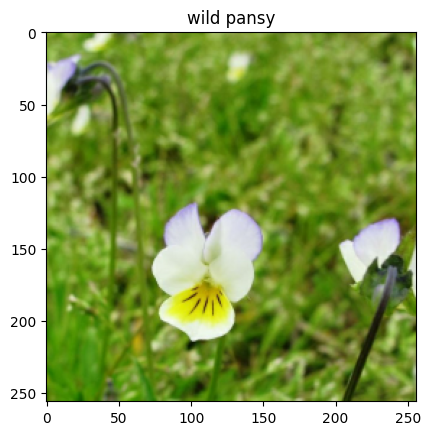

In [181]:
model = tf.keras.models.load_model('image_net_30epochs')
test_img = next(iter(ds_valid))[0][13]
y_pred = np.argmax(model(np.expand_dims(test_img, axis=0)))
plt.imshow(test_img)
plt.title(CLASSES[y_pred])

In [182]:
from sklearn.neighbors import NearestNeighbors

ds_knn = get_dataset_for_KNN(y_pred)

with strategy.scope():
  base_model = tf.keras.models.load_model('image_net_30epochs')
  #base_model = model
  model_similarity = tf.keras.Model(inputs=base_model.input, outputs=base_model.get_layer('global_max_pooling2d').output)

knn = NearestNeighbors(metric='cosine', algorithm='auto')
knn.fit(model_similarity.predict(ds_knn))

ds_knn_list = list(ds_knn.as_numpy_iterator())
ds_knn_arr = np.array(list(map(lambda x: x[0], ds_knn_list))[0])

1/1 [==============================] - 11s 11s/step


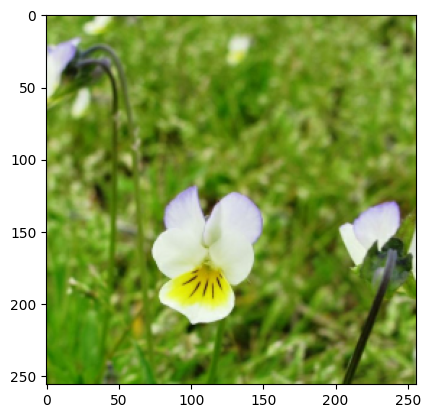

In [183]:
vec = model_similarity(np.expand_dims(test_img, axis=0))
dist, indices = knn.kneighbors(vec, n_neighbors=3)
plt.imshow(test_img)

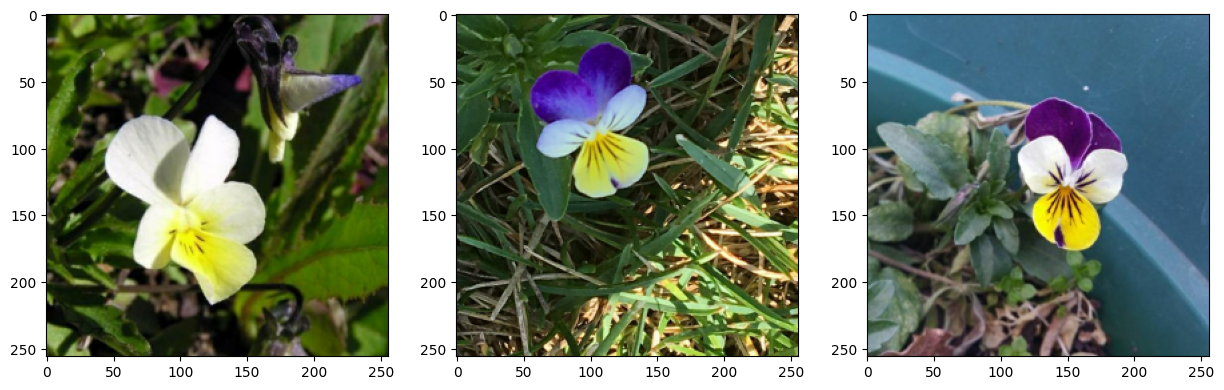

In [184]:
order = np.argsort(dist)[0]
similar_imgs = ds_knn_arr[indices[0][order]].reshape((-1, *IMAGE_SIZE, 3))
fig, axs = plt.subplots(1, 3, figsize=(15, 15))
for i, img in enumerate(similar_imgs):
  axs[i].imshow(img)